In [1]:
import os, sys
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Audio read

In [2]:
FFMPEG_BIN_PATH = "./ffmpeg-4.1.4-macos64-static/bin/"

In [3]:
audio_path = "Audio/Voix_190716.3gp"

In [4]:
def get_audio_info(audio_path, FFMPEG_BIN_PATH):
    ffprobe_path = os.path.join(FFMPEG_BIN_PATH, "ffprobe")
    cmd = "{executable} -i {audio_file} -hide_banner".format(executable=ffprobe_path, audio_file=audio_path)
    completed_process = subprocess.run(cmd.split(), capture_output=True)
    info = completed_process.stderr.decode()
    return info

In [5]:
info = get_audio_info(audio_path, FFMPEG_BIN_PATH)

In [6]:
def get_buffer_size_from_duration(duration_string, sampling_rate, offset=500):
    from datetime import datetime
    dtime = datetime.strptime("00:02:02.18", "%H:%M:%S.%f")
    total_second = dtime.minute * 60 + dtime.second + (dtime.microsecond / 10**6)
    sample_number = total_second * sampling_rate + offset
    buffer_size = int(sample_number) * 2
    return buffer_size

In [7]:
command = "{ffmpeg} -i {audio_file} -f {format} -ar 44100 -ac 1 -".format(ffmpeg=os.path.join(FFMPEG_BIN_PATH,'ffmpeg'), 
                                                           audio_file=audio_path,
                                                           format='s16le')
buffersize = get_buffer_size_from_duration("00:02:02.18", 44100)
pipe = subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'), 
                        bufsize=buffersize)
raw = pipe.stdout.read(buffersize)
audio = np.frombuffer(raw, dtype=np.int16)

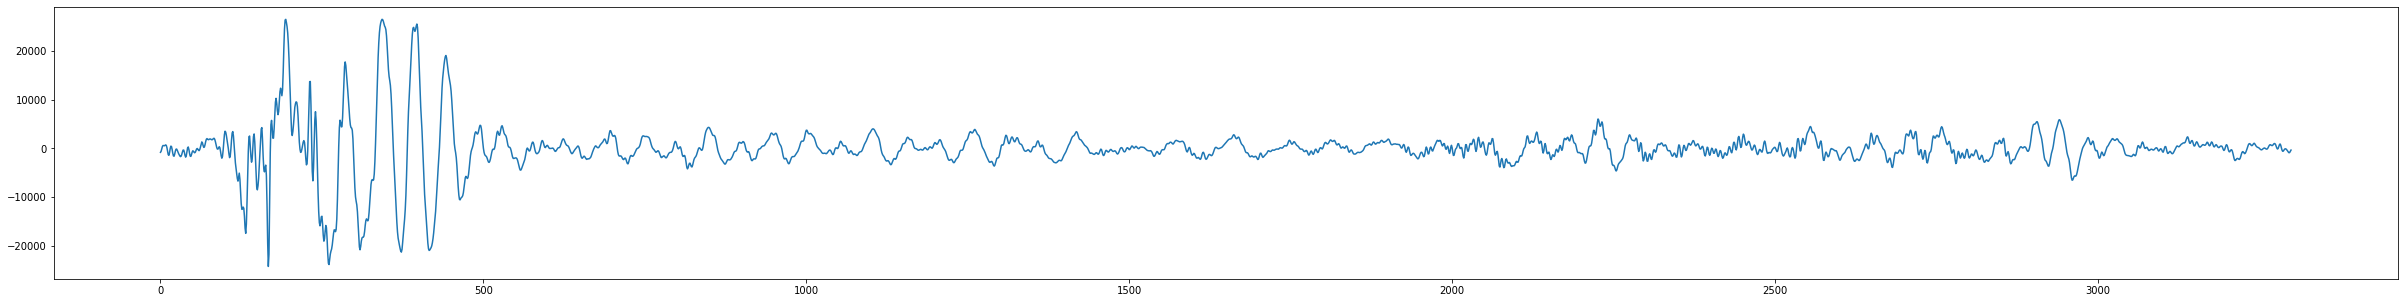

In [28]:
# full_1 = audio[490000:520000]
frappe_1 = audio[491200:494500]
plt.plot(frappe_1)
plt.xlim = 0
fig = plt.gcf()
fig.set_size_inches(42,5)

## Analysis

In [9]:
sound_speed = 340.29

In [10]:
def convert_ft_to_m(feets):
    return feets * 0.3048

In [11]:
def pixel_distance(l, h):
    return np.sqrt(l**2 + h**2)

In [12]:
#double echo time delay
d_1 = 8
d_2 = 11.79
print("First Echo after : {:.5}s".format(2 * (d_1 / sound_speed)))
print("First Echo after : {:.5}s".format(2 * (d_2 / sound_speed)))

First Echo after : 0.047019s
First Echo after : 0.069294s


In [13]:
sound_speed * 0.016

5.444640000000001

In [14]:
(d_2 - d_1) * 2

7.579999999999998

In [15]:
def v(d, t):
    return d/t

def convert_ms_to_kmh(v):
    return v * 3.6

In [16]:
d1_p = pixel_distance(2171, 14)
d1_r = 5.4864
d2_p = pixel_distance(4633, 33)
d = (d2_p * d1_r) / d1_p
d = 11.70
t = 0.332
convert_ms_to_kmh(v(d, t))

126.86746987951805

In [17]:
(2.3 / 340.29)

0.006758940903347144

In [18]:
"{:.7f}".format(1/44100)

'0.0000227'